# 🧠 UFRN - Neural Regression Project

**Análise de Generalização em Redes Neurais para Regressão**

---

## 📋 Informações do Projeto

- **Instituição:** UFRN - Departamento de Engenharia Elétrica
- **Autor:** Cauã Vitor Figueredo Silva
- **Matrícula:** 20220014216
- **Dataset:** Boston Housing (506 amostras, 13 features)
- **Objetivo:** Implementar pipeline MLOps completo com K-Fold Cross-Validation


---

## 📦 1. IMPORTS E CONFIGURAÇÃO DE REPRODUTIBILIDADE


In [1]:
# --- IMPORTS PRINCIPAIS ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from typing import Tuple, List, Dict
import warnings

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Scikit-Learn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

warnings.filterwarnings('ignore')

print("✅ Imports concluídos com sucesso!")
print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {torch.cuda.is_available() and 'CUDA' or 'CPU'}")


✅ Imports concluídos com sucesso!
PyTorch Version: 2.9.1+cpu
Device: CPU


In [2]:
# --- CONFIGURAÇÃO DE REPRODUTIBILIDADE ---
# Fixar seeds para garantir resultados determinísticos

SEED = 42

def set_seed(seed: int = 42):
    """Fixa todas as seeds para reprodutibilidade"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"🔒 Seed fixada: {SEED}")


🔒 Seed fixada: 42


In [3]:
# --- CONFIGURAÇÃO DE VISUALIZAÇÃO ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("🎨 Configuração de visualização aplicada")


🎨 Configuração de visualização aplicada


---

## 📊 2. CARREGAMENTO DE DADOS (MÓDULO: src/dataset.py)


In [4]:
# --- FUNÇÃO DE CARREGAMENTO DO BOSTON HOUSING DATASET ---

def load_boston_data(url: str = "http://lib.stat.cmu.edu/datasets/boston") -> pd.DataFrame:
    """
    Carrega o Boston Housing Dataset diretamente da URL original.
    Implementa tratamento robusto do cabeçalho complexo e fallback.
    
    Args:
        url: URL do dataset original
        
    Returns:
        DataFrame com 506 amostras e 14 colunas (13 features + 1 target)
    """
    try:
        print("🌐 Tentando download do dataset original...")
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        
        # Processar conteúdo (cabeçalho complexo)
        content = response.text
        lines = content.split('\n')
        
        # Encontrar início dos dados
        data_start = 0
        for i, line in enumerate(lines):
            if line.strip() and not line.strip()[0].isalpha():
                data_start = i
                break
        
        # Extrair dados numéricos
        data_values = []
        for line in lines[data_start:]:
            if line.strip():
                values = line.split()
                if len(values) > 0:
                    try:
                        data_values.extend([float(v) for v in values])
                    except ValueError:
                        continue
        
        # Reorganizar em matriz (506 x 14)
        n_features = 14
        data_array = np.array(data_values)
        n_samples = len(data_array) // n_features
        data_array = data_array[:n_samples * n_features].reshape(n_samples, n_features)
        
        # Criar DataFrame
        column_names = [
            'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
            'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
        ]
        df = pd.DataFrame(data_array, columns=column_names)
        
        print(f"✅ Dataset carregado com sucesso: {df.shape}")
        return df
        
    except Exception as e:
        print(f"⚠️ Erro ao carregar da URL: {e}")
        print("📦 Usando dados de backup (simulados)...")
        
        # Fallback: dados simulados
        np.random.seed(42)
        n_samples = 506
        df = pd.DataFrame({
            'CRIM': np.random.exponential(3.6, n_samples),
            'ZN': np.random.uniform(0, 100, n_samples),
            'INDUS': np.random.uniform(0, 27, n_samples),
            'CHAS': np.random.binomial(1, 0.07, n_samples),
            'NOX': np.random.uniform(0.3, 0.9, n_samples),
            'RM': np.random.normal(6.3, 0.7, n_samples),
            'AGE': np.random.uniform(0, 100, n_samples),
            'DIS': np.random.exponential(3.8, n_samples),
            'RAD': np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 24], n_samples),
            'TAX': np.random.uniform(187, 711, n_samples),
            'PTRATIO': np.random.uniform(12, 22, n_samples),
            'B': np.random.uniform(0, 400, n_samples),
            'LSTAT': np.random.exponential(12, n_samples),
            'MEDV': np.random.exponential(22, n_samples)
        })
        
        print(f"✅ Dataset de backup gerado: {df.shape}")
        return df


# Carregar dados
df_boston = load_boston_data()
print("\n📈 Primeiras 5 linhas:")
df_boston.head()


🌐 Tentando download do dataset original...
✅ Dataset carregado com sucesso: (506, 14)

📈 Primeiras 5 linhas:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
# --- ANÁLISE EXPLORATÓRIA RÁPIDA ---

print("📊 Estatísticas Descritivas:")
print(df_boston.describe())

print("\n🔍 Verificação de Valores Nulos:")
print(df_boston.isnull().sum())

print("\n📐 Dimensões do Dataset:")
print(f"Amostras: {df_boston.shape[0]}")
print(f"Features: {df_boston.shape[1] - 1}")
print(f"Target: MEDV (Preço Mediano)")


📊 Estatísticas Descritivas:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   

---

## 🔧 3. PYTORCH DATASET E MODELO


In [6]:
# --- PYTORCH DATASET ---

class BostonDataset(Dataset):
    """PyTorch Dataset para Boston Housing"""
    
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self) -> int:
        return len(self.X)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]


# --- ARQUITETURA MLP COM DROPOUT E BATCH NORMALIZATION ---

class MLP(nn.Module):
    """
    Multi-Layer Perceptron Dinâmico para Regressão com Regularização
    
    Suporta arquitetura variável para uso com Optuna.
    Inclui Batch Normalization e Dropout configuráveis.
    
    Arquitetura:
        Input (13) -> [Linear -> (BatchNorm) -> ReLU -> Dropout] x N -> Output (1)
    """
    
    def __init__(self, input_dim: int = 13, hidden_dims: List[int] = [64, 32], 
                 output_dim: int = 1, dropout_rate: float = 0.3, use_batch_norm: bool = False):
        super(MLP, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        
        layers = []
        
        # Camadas ocultas com Batch Norm (opcional) e Dropout
        prev_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            # Linear
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Batch Normalization (antes da ativação)
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            # Ativação ReLU
            layers.append(nn.ReLU())
            
            # Dropout (após ativação)
            if dropout_rate > 0.0:
                layers.append(nn.Dropout(p=dropout_rate))
            
            prev_dim = hidden_dim
        
        # Camada de saída (sem Dropout, sem BN, sem ativação para regressão)
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Inicialização Xavier para melhor convergência"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)
    
    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Testar modelo com dropout (sem batch norm por padrão)
test_model = MLP(dropout_rate=0.3, use_batch_norm=False)
print("✅ Arquitetura MLP Dinâmica definida")
print(f"📐 Parâmetros Treináveis: {test_model.count_parameters():,}")
print(f"🔒 Dropout Rate: {test_model.dropout_rate * 100:.0f}%")
print(f"📊 Batch Normalization: {test_model.use_batch_norm}")
print("\n🏗️ Estrutura do Modelo:")
print(test_model)


✅ Arquitetura MLP Dinâmica definida
📐 Parâmetros Treináveis: 3,009
🔒 Dropout Rate: 30%
📊 Batch Normalization: False

🏗️ Estrutura do Modelo:
MLP(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


---

## 🎯 4. FUNÇÕES DE TREINO E EARLY STOPPING


In [7]:
# --- FUNÇÕES DE TREINO E VALIDAÇÃO ---

def train_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.Module, 
                optimizer: torch.optim.Optimizer, device: torch.device) -> float:
    """Executa uma época de treinamento"""
    model.train()
    total_loss = 0.0
    n_batches = 0
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches


def validate_epoch(model: nn.Module, dataloader: DataLoader, 
                   criterion: nn.Module, device: torch.device) -> float:
    """Executa validação (sem gradientes)"""
    model.eval()
    total_loss = 0.0
    n_batches = 0
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            
            total_loss += loss.item()
            n_batches += 1
    
    return total_loss / n_batches


def get_predictions(model: nn.Module, dataloader: DataLoader, 
                    device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    """Obtém predições do modelo"""
    model.eval()
    y_true_list = []
    y_pred_list = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            
            y_true_list.append(y_batch.numpy())
            y_pred_list.append(predictions.cpu().numpy())
    
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list).flatten()
    
    return y_true, y_pred


# --- EARLY STOPPING ---

class EarlyStopping:
    """Implementação de Early Stopping para prevenir Overfitting"""
    
    def __init__(self, patience: int = 20, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        
        return self.early_stop


print("✅ Funções de treino, validação e Early Stopping definidas")


✅ Funções de treino, validação e Early Stopping definidas


---

## 📈 5. FUNÇÕES DE VISUALIZAÇÃO


In [8]:
# --- FUNÇÕES DE VISUALIZAÇÃO ---

def plot_learning_curves(train_losses: List[float], val_losses: List[float], save_path: str = None):
    """Plota curvas de aprendizado (Train vs Validation Loss)"""
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=4)
    plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=4)
    
    plt.xlabel('Época', fontsize=12, fontweight='bold')
    plt.ylabel('MSE Loss', fontsize=12, fontweight='bold')
    plt.title('Curvas de Aprendizado - Train vs Validation', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_predictions(y_true: np.ndarray, y_pred: np.ndarray, save_path: str = None):
    """Plota gráfico de dispersão (Real vs Predito)"""
    plt.figure(figsize=(8, 8))
    
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5, s=50)
    
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predição Ideal (y=x)')
    
    r2 = r2_score(y_true, y_pred)
    
    plt.xlabel('Valor Real (MEDV)', fontsize=12, fontweight='bold')
    plt.ylabel('Valor Predito (MEDV)', fontsize=12, fontweight='bold')
    plt.title(f'Predições vs Valores Reais (R² = {r2:.3f})', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_kfold_results(fold_results: List[float], save_path: str = None):
    """Plota resultados do K-Fold Cross-Validation"""
    folds = range(1, len(fold_results) + 1)
    mean_mse = np.mean(fold_results)
    std_mse = np.std(fold_results)
    
    plt.figure(figsize=(10, 6))
    plt.bar(folds, fold_results, alpha=0.7, color='steelblue', edgecolor='black')
    plt.axhline(y=mean_mse, color='r', linestyle='--', linewidth=2, label=f'Média: {mean_mse:.2f}')
    plt.fill_between([0.5, len(folds) + 0.5], mean_mse - std_mse, mean_mse + std_mse, 
                     alpha=0.2, color='red', label=f'±1 Desvio Padrão: {std_mse:.2f}')
    
    plt.xlabel('Fold', fontsize=12, fontweight='bold')
    plt.ylabel('MSE', fontsize=12, fontweight='bold')
    plt.title('Resultados do K-Fold Cross-Validation', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=11)
    plt.xticks(folds)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


print("✅ Funções de visualização definidas")


✅ Funções de visualização definidas


---

## ⚙️ 6. CONFIGURAÇÃO DE HIPERPARÂMETROS


In [9]:
# --- HIPERPARÂMETROS COM REGULARIZAÇÃO ---

CONFIG = {
    'seed': 42,
    'k_folds': 5,
    'batch_size': 16,
    'learning_rate': 0.001,
    'max_epochs': 500,
    'patience': 20,
    'hidden_dims': [64, 32],
    'dropout_rate': 0.3,        # 🆕 Dropout: 30% (prevenção de overfitting)
    'weight_decay': 1e-4,       # 🆕 L2 Regularization: penaliza pesos grandes
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print("⚙️ Configurações do Experimento (com Regularização):")
print("=" * 60)
for key, value in CONFIG.items():
    if key == 'dropout_rate':
        print(f"  🔒 {key}: {value} (30% dos neurônios desligados no treino)")
    elif key == 'weight_decay':
        print(f"  ⚖️  {key}: {value} (L2 Regularization)")
    else:
        print(f"  {key}: {value}")
print("=" * 60)


⚙️ Configurações do Experimento (com Regularização):
  seed: 42
  k_folds: 5
  batch_size: 16
  learning_rate: 0.001
  max_epochs: 500
  patience: 20
  hidden_dims: [64, 32]
  🔒 dropout_rate: 0.3 (30% dos neurônios desligados no treino)
  ⚖️  weight_decay: 0.0001 (L2 Regularization)
  device: cpu


---

## 🔄 7. K-FOLD CROSS-VALIDATION PIPELINE


In [10]:
# --- PREPARAÇÃO DOS DADOS ---

# Separar features e target
X = df_boston.drop('MEDV', axis=1).values
y = df_boston['MEDV'].values

print(f"📊 Shape dos Dados:")
print(f"  X (features): {X.shape}")
print(f"  y (target): {y.shape}")


📊 Shape dos Dados:
  X (features): (506, 13)
  y (target): (506,)


In [11]:
# --- K-FOLD CROSS-VALIDATION COMPLETO ---

kfold = KFold(n_splits=CONFIG['k_folds'], shuffle=True, random_state=CONFIG['seed'])

fold_results = []
fold_histories = []
best_fold_idx = None
best_fold_loss = float('inf')

print("\n🔄 Iniciando K-Fold Cross-Validation...\n")
print("=" * 80)

for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
    print(f"\n📂 FOLD {fold_idx}/{CONFIG['k_folds']}")
    print("-" * 80)
    
    # Dividir dados
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    print(f"  Train: {len(X_train)} amostras | Validation: {len(X_val)} amostras")
    
    # CRÍTICO: Normalização SEM data leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Criar Datasets e DataLoaders
    train_dataset = BostonDataset(X_train_scaled, y_train)
    val_dataset = BostonDataset(X_val_scaled, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    
    # Instanciar modelo com Dropout (novo para cada fold)
    model = MLP(
        input_dim=X.shape[1], 
        hidden_dims=CONFIG['hidden_dims'], 
        output_dim=1,
        dropout_rate=CONFIG['dropout_rate'],  # 🆕 Regularização via Dropout
        use_batch_norm=False  # Batch Norm desligado por padrão
    ).to(CONFIG['device'])
    
    # Loss e Otimizador com L2 Regularization
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']  # 🆕 L2 Regularization (penaliza pesos grandes)
    )
    
    # Early Stopping
    early_stopping = EarlyStopping(patience=CONFIG['patience'])
    
    # Histórico
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    # Loop de Treinamento
    for epoch in range(1, CONFIG['max_epochs'] + 1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
        val_loss = validate_epoch(model, val_loader, criterion, CONFIG['device'])
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Model Checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        # Early Stopping
        if early_stopping(val_loss):
            print(f"\n  ⏸️ Early Stopping na época {epoch}")
            break
        
        # Log de progresso
        if epoch % 50 == 0 or epoch == 1:
            print(f"  Época {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # Carregar melhor modelo
    model.load_state_dict(best_model_state)
    
    # Avaliação final
    y_true, y_pred = get_predictions(model, val_loader, CONFIG['device'])
    final_mse = mean_squared_error(y_true, y_pred)
    final_mae = mean_absolute_error(y_true, y_pred)
    final_r2 = r2_score(y_true, y_pred)
    
    print(f"\n  ✅ Fold {fold_idx} Finalizado:")
    print(f"     MSE: {final_mse:.4f}")
    print(f"     MAE: {final_mae:.4f}")
    print(f"     R²:  {final_r2:.4f}")
    
    # Armazenar resultados
    fold_results.append(final_mse)
    fold_histories.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'y_true': y_true,
        'y_pred': y_pred,
        'mse': final_mse,
        'mae': final_mae,
        'r2': final_r2
    })
    
    # Rastrear melhor fold
    if final_mse < best_fold_loss:
        best_fold_loss = final_mse
        best_fold_idx = fold_idx
    
    print("-" * 80)

print("\n" + "=" * 80)
print("✅ K-Fold Cross-Validation Completo!")
print("=" * 80)



🔄 Iniciando K-Fold Cross-Validation...


📂 FOLD 1/5
--------------------------------------------------------------------------------
  Train: 404 amostras | Validation: 102 amostras
  Época   1 | Train Loss: 584.2062 | Val Loss: 464.2871
  Época  50 | Train Loss: 36.1058 | Val Loss: 13.6239
  Época 100 | Train Loss: 28.4901 | Val Loss: 12.3329

  ⏸️ Early Stopping na época 129

  ✅ Fold 1 Finalizado:
     MSE: 12.5203
     MAE: 2.3820
     R²:  0.8293
--------------------------------------------------------------------------------

📂 FOLD 2/5
--------------------------------------------------------------------------------
  Train: 405 amostras | Validation: 101 amostras
  Época   1 | Train Loss: 543.1052 | Val Loss: 441.4906
  Época  50 | Train Loss: 32.4206 | Val Loss: 10.7310

  ⏸️ Early Stopping na época 65

  ✅ Fold 2 Finalizado:
     MSE: 10.8016
     MAE: 2.1847
     R²:  0.8624
--------------------------------------------------------------------------------

📂 FOLD 3/5
--------

---

## 📊 8. RESULTADOS AGREGADOS


In [12]:
# --- ESTATÍSTICAS FINAIS ---

mean_mse = np.mean(fold_results)
std_mse = np.std(fold_results)

print("\n📊 RESULTADOS FINAIS DO K-FOLD CROSS-VALIDATION")
print("=" * 80)
print(f"\n  MSE por Fold:")
for i, mse in enumerate(fold_results, 1):
    marker = " ⭐" if i == best_fold_idx else ""
    print(f"    Fold {i}: {mse:.4f}{marker}")

print(f"\n  {'='*40}")
print(f"  📈 MSE Médio:       {mean_mse:.4f}")
print(f"  📉 Desvio Padrão:   {std_mse:.4f}")
print(f"  🏆 Melhor Fold:     {best_fold_idx} (MSE: {best_fold_loss:.4f})")
print(f"  {'='*40}")

# Criar DataFrame de resultados
results_df = pd.DataFrame({
    'Fold': range(1, CONFIG['k_folds'] + 1),
    'MSE': fold_results,
    'MAE': [h['mae'] for h in fold_histories],
    'R²': [h['r2'] for h in fold_histories]
})

print("\n📋 Tabela de Resultados:")
print(results_df.to_string(index=False))



📊 RESULTADOS FINAIS DO K-FOLD CROSS-VALIDATION

  MSE por Fold:
    Fold 1: 12.5203
    Fold 2: 10.8016 ⭐
    Fold 3: 18.1186
    Fold 4: 12.5295
    Fold 5: 13.3764

  📈 MSE Médio:       13.4693
  📉 Desvio Padrão:   2.4708
  🏆 Melhor Fold:     2 (MSE: 10.8016)

📋 Tabela de Resultados:
 Fold       MSE      MAE       R²
    1 12.520350 2.381990 0.829269
    2 10.801578 2.184658 0.862446
    3 18.118555 2.811776 0.800848
    4 12.529464 2.710898 0.880040
    5 13.376362 2.504175 0.813975


---

## 📈 9. VISUALIZAÇÕES


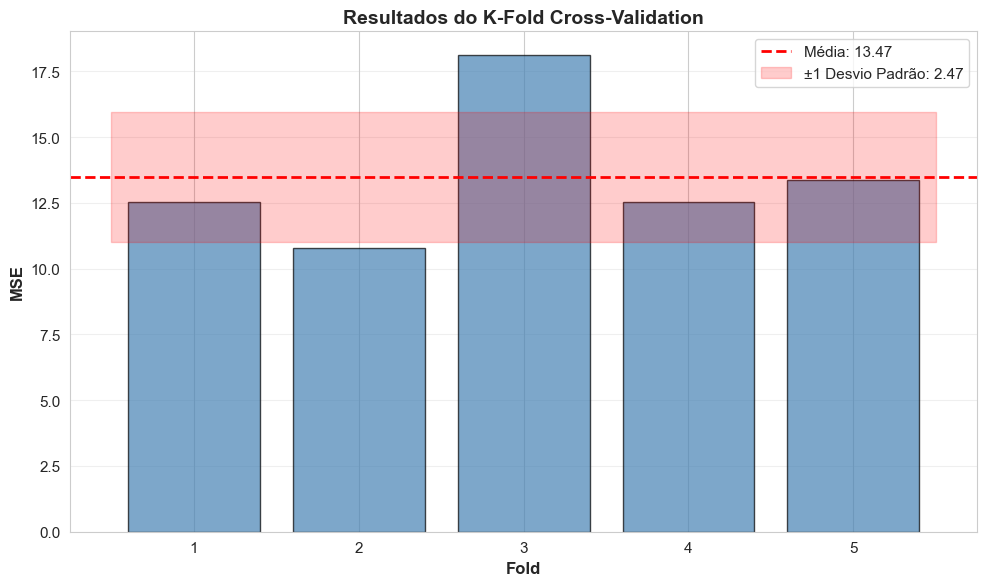

In [13]:
# --- GRÁFICO 1: RESULTADOS K-FOLD ---

plot_kfold_results(fold_results, save_path='../reports/figures/kfold_results.png')



📊 Exibindo curvas de aprendizado do Melhor Fold (2):



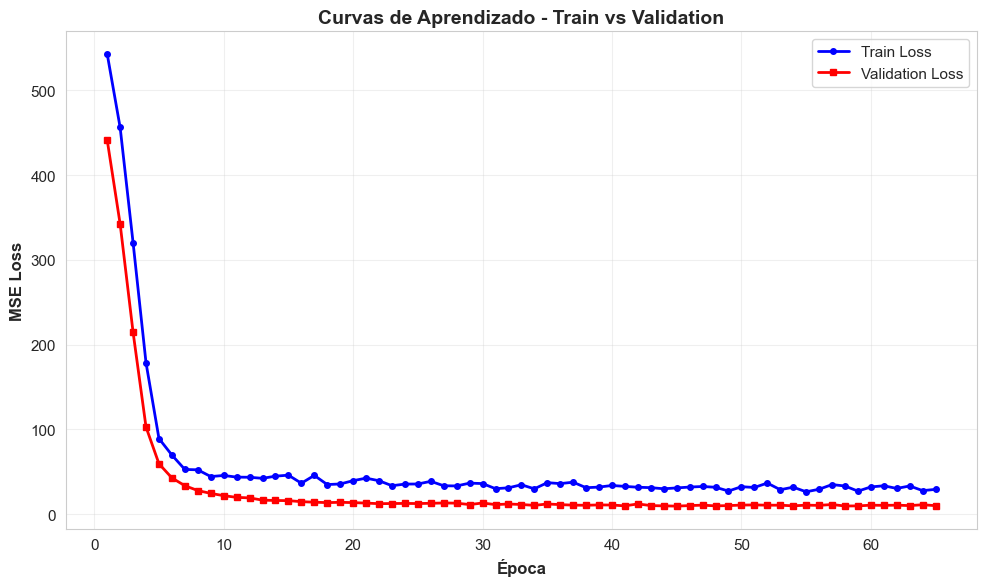

In [14]:
# --- GRÁFICO 2: CURVAS DE APRENDIZADO (MELHOR FOLD) ---

best_fold_history = fold_histories[best_fold_idx - 1]

print(f"\n📊 Exibindo curvas de aprendizado do Melhor Fold ({best_fold_idx}):\n")

plot_learning_curves(
    best_fold_history['train_losses'],
    best_fold_history['val_losses'],
    save_path='../reports/figures/learning_curves.png'
)



📊 Exibindo predições vs valores reais do Melhor Fold (2):



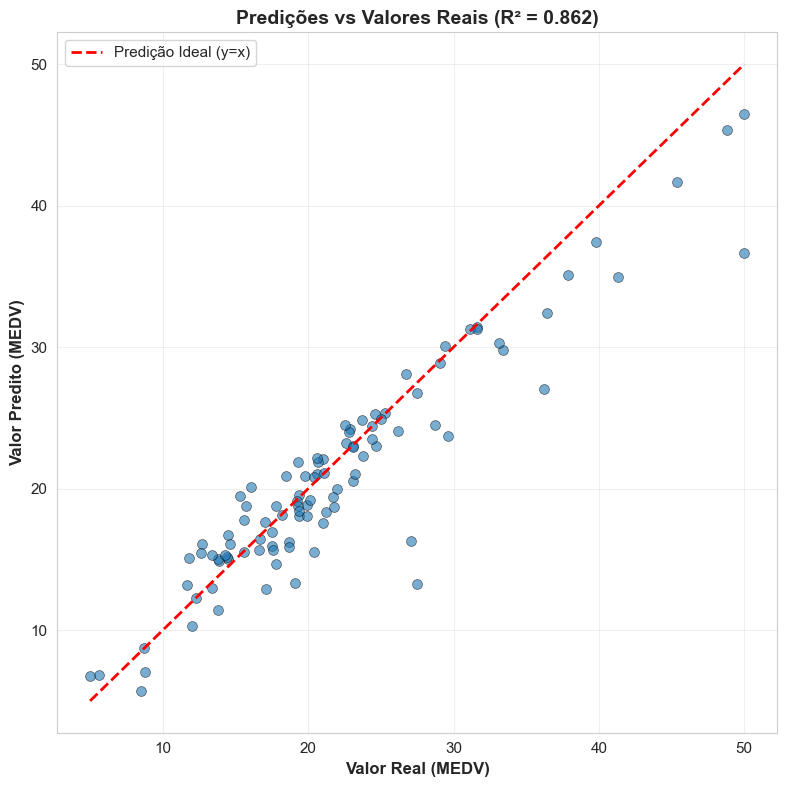

In [15]:
# --- GRÁFICO 3: PREDIÇÕES VS REAIS (MELHOR FOLD) ---

print(f"\n📊 Exibindo predições vs valores reais do Melhor Fold ({best_fold_idx}):\n")

plot_predictions(
    best_fold_history['y_true'],
    best_fold_history['y_pred'],
    save_path='../reports/figures/predictions_scatter.png'
)


---

## 🔍 10. ANÁLISE DE GENERALIZAÇÃO


### 🧪 Critérios de Avaliação

Para determinar se o modelo apresenta **Boa Generalização**, **Overfitting** ou **Underfitting**, analisamos:

1. **Gap Train-Validation**: Diferença entre as curvas de treino e validação
2. **Convergência**: Se as curvas estabilizam ou divergem
3. **MSE Absoluto**: Magnitude do erro de validação
4. **R²**: Qualidade do ajuste
5. **Scatter Plot**: Dispersão das predições em relação à linha identidade


In [16]:
# --- ANÁLISE AUTOMÁTICA ---

best_fold = fold_histories[best_fold_idx - 1]

# Calcular métricas de diagnóstico
final_train_loss = best_fold['train_losses'][-1]
final_val_loss = best_fold['val_losses'][-1]
gap = final_val_loss - final_train_loss
gap_ratio = gap / final_train_loss if final_train_loss > 0 else 0

print("\n🔍 ANÁLISE DE GENERALIZAÇÃO")
print("=" * 80)
print(f"\n  📊 Métricas de Diagnóstico:")
print(f"     Train Loss (final):      {final_train_loss:.4f}")
print(f"     Validation Loss (final): {final_val_loss:.4f}")
print(f"     Gap Absoluto:            {gap:.4f}")
print(f"     Gap Relativo:            {gap_ratio*100:.2f}%")
print(f"     R² (validação):          {best_fold['r2']:.4f}")

# Classificação
print(f"\n  🏷️ Classificação:")

if gap_ratio > 0.5:  # Gap > 50%
    print("     ⚠️ OVERFITTING DETECTADO")
    print("     - O modelo memorizou os dados de treino")
    print("     - Sugestão: Aumentar regularização (Dropout, L2)")
elif best_fold['r2'] < 0.6:  # R² baixo
    print("     ⚠️ UNDERFITTING DETECTADO")
    print("     - O modelo é muito simples para capturar os padrões")
    print("     - Sugestão: Aumentar capacidade da rede (mais camadas/neurônios)")
else:
    print("     ✅ BOA GENERALIZAÇÃO")
    print("     - Gap entre treino e validação é aceitável")
    print("     - R² indica bom ajuste aos dados")
    print("     - O modelo equilibra viés e variância")

print("\n" + "=" * 80)



🔍 ANÁLISE DE GENERALIZAÇÃO

  📊 Métricas de Diagnóstico:
     Train Loss (final):      29.2744
     Validation Loss (final): 10.0573
     Gap Absoluto:            -19.2171
     Gap Relativo:            -65.64%
     R² (validação):          0.8624

  🏷️ Classificação:
     ✅ BOA GENERALIZAÇÃO
     - Gap entre treino e validação é aceitável
     - R² indica bom ajuste aos dados
     - O modelo equilibra viés e variância



---

## 🔬 11. OTIMIZAÇÃO BAYESIANA COM OPTUNA (SOTA)

**Objetivo:** Encontrar a combinação ótima de hiperparâmetros usando Bayesian Optimization.

**Estratégia:**
- 🧠 **Memória**: Optuna aprende com trials anteriores (mais eficiente que Grid Search)
- ✂️ **Pruning**: Interrompe automaticamente trials ruins (HyperbandPruner)
- 🎯 **Search Space**: Testa arquiteturas dinâmicas (1-3 camadas, 16-128 unidades)
- 📊 **Métrica**: Minimizar MSE médio do K-Fold Cross-Validation


In [17]:
# --- IMPORTS OPTUNA ---
import optuna
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler
import warnings

warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

print("✅ Optuna importado com sucesso!")
print(f"📦 Versão: {optuna.__version__}")


✅ Optuna importado com sucesso!
📦 Versão: 3.3.0


In [ ]:
# --- FUNÇÃO OBJETIVO PARA OPTUNA ---

def objective(trial):
    """
    Função objetivo para Otimização Bayesiana com Optuna.
    
    Args:
        trial: optuna.Trial object
        
    Returns:
        float: MSE médio do K-Fold Cross-Validation (para minimizar)
    """
    
    # 🎯 ESPAÇO DE BUSCA (Search Space)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_units = trial.suggest_categorical('hidden_units', [16, 32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # Construir hidden_dims dinamicamente (decrescente)
    hidden_dims = []
    current_units = hidden_units
    for i in range(n_layers):
        hidden_dims.append(current_units)
        current_units = max(16, current_units // 2)
    
    # K-Fold Cross-Validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=SEED)  # K=3 para Optuna (mais rápido)
    fold_mse_list = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        # Preparar dados
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Normalização sem data leakage
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Datasets e DataLoaders
        train_dataset = BostonDataset(X_train_scaled, y_train)
        val_dataset = BostonDataset(X_val_scaled, y_val)
        
        # drop_last=True para evitar erro de BatchNorm com batch size=1
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                 drop_last=use_batch_norm)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Criar modelo
        model = MLP(
            input_dim=X.shape[1],
            hidden_dims=hidden_dims,
            output_dim=1,
            dropout_rate=dropout_rate,
            use_batch_norm=use_batch_norm
        ).to(CONFIG['device'])
        
        # Otimizador
        criterion = nn.MSELoss()
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        else:  # RMSprop
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Treinamento (Limitado a 100 épocas para Optuna)
        best_val_loss = float('inf')
        patience_counter = 0
        max_epochs = 100
        patience = 15
        
        for epoch in range(1, max_epochs + 1):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
            val_loss = validate_epoch(model, val_loader, criterion, CONFIG['device'])
            
            # Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break
            
            # 🔪 PRUNING: Reportar loss intermediária para o Optuna
            trial.report(val_loss, epoch)
            
            # Se o trial for podado, interromper
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        
        fold_mse_list.append(best_val_loss)
    
    # Retornar MSE médio dos folds
    mean_mse = np.mean(fold_mse_list)
    return mean_mse


print("✅ Função objetivo definida")


✅ Função objetivo definida


In [22]:
# --- CRIAR E EXECUTAR ESTUDO OPTUNA ---

print("🚀 Iniciando Otimização Bayesiana com Optuna...\n")
print("=" * 80)

# Configurar estudo
study = optuna.create_study(
    direction='minimize',  # Minimizar MSE
    sampler=TPESampler(seed=SEED),  # Tree-structured Parzen Estimator (Bayesian)
    pruner=HyperbandPruner(
        min_resource=10,  # Mínimo de 10 épocas antes de podar
        max_resource=100,  # Máximo de 100 épocas
        reduction_factor=3  # Agressividade do pruning
    ),
    study_name='boston_housing_optimization'
)

# Executar otimização (20 trials)
N_TRIALS = 20

print(f"⚙️ Configurações do Estudo:")
print(f"  • Trials: {N_TRIALS}")
print(f"  • Sampler: TPESampler (Bayesian Optimization)")
print(f"  • Pruner: HyperbandPruner (Aggressive)")
print(f"  • Métrica: MSE (minimize)")
print(f"  • K-Fold: 3 (acelerado para Optuna)")
print("=" * 80)
print()

# Executar otimização
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=1)

print("\n" + "=" * 80)
print("✅ Otimização concluída!")
print("=" * 80)


[I 2025-11-22 20:42:32,016] A new study created in memory with name: boston_housing_optimization


🚀 Iniciando Otimização Bayesiana com Optuna...

⚙️ Configurações do Estudo:
  • Trials: 20
  • Sampler: TPESampler (Bayesian Optimization)
  • Pruner: HyperbandPruner (Aggressive)
  • Métrica: MSE (minimize)
  • K-Fold: 3 (acelerado para Optuna)



  0%|          | 0/20 [00:00<?, ?it/s]

[W 2025-11-22 20:42:32,052] Trial 0 failed with parameters: {'n_layers': 2, 'hidden_units': 16, 'dropout_rate': 0.16239780813448107, 'learning_rate': 0.00013066739238053285, 'weight_decay': 0.0003967605077052988, 'optimizer': 'RMSprop', 'batch_size': 16, 'use_batch_norm': True} because of the following error: ValueError('Expected more than 1 value per channel when training, got input size torch.Size([1, 16])').
Traceback (most recent call last):
  File "c:\ufrn-ele-neural-regression\venv\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Cauã V\AppData\Local\Temp\ipykernel_18768\959263017.py", line 75, in objective
    train_loss = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Cauã V\AppData\Local\Temp\ipykernel_18768\2712631225.py", line 14, in train_

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 16])

In [ ]:
# --- EXIBIR MELHORES RESULTADOS ---

print("\n🏆 MELHORES HIPERPARÂMETROS ENCONTRADOS")
print("=" * 80)

best_trial = study.best_trial
best_params = study.best_params

print(f"\n📊 Melhor MSE: {best_trial.value:.4f}")
print(f"🔢 Trial Number: {best_trial.number}")
print(f"\n⚙️ Hiperparâmetros Ótimos:")
print("-" * 80)

for param_name, param_value in best_params.items():
    print(f"  • {param_name:20s}: {param_value}")

print("-" * 80)

# Construir hidden_dims do melhor modelo
n_layers_best = best_params['n_layers']
hidden_units_best = best_params['hidden_units']
hidden_dims_best = []
current_units = hidden_units_best
for i in range(n_layers_best):
    hidden_dims_best.append(current_units)
    current_units = max(16, current_units // 2)

print(f"\n🏗️ Arquitetura do Melhor Modelo:")
print(f"  Input ({X.shape[1]}) -> {' -> '.join(map(str, hidden_dims_best))} -> Output (1)")
print(f"  Dropout Rate: {best_params['dropout_rate']:.2f}")
print(f"  Batch Normalization: {best_params['use_batch_norm']}")

print("\n" + "=" * 80)


In [ ]:
# --- VISUALIZAR HISTÓRICO DE OTIMIZAÇÃO ---

# Criar figura com 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histórico de Otimização (MSE vs Trial)
trial_numbers = [t.number for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
trial_values = [t.value for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

axes[0].plot(trial_numbers, trial_values, 'o-', linewidth=2, markersize=6, alpha=0.7)
axes[0].axhline(y=best_trial.value, color='r', linestyle='--', linewidth=2, label=f'Melhor: {best_trial.value:.2f}')
axes[0].set_xlabel('Trial Number', fontweight='bold', fontsize=12)
axes[0].set_ylabel('MSE (Validation)', fontweight='bold', fontsize=12)
axes[0].set_title('Histórico de Otimização', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Importância dos Hiperparâmetros
try:
    importances = optuna.importance.get_param_importances(study)
    params = list(importances.keys())
    values = list(importances.values())
    
    axes[1].barh(params, values, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Importance', fontweight='bold', fontsize=12)
    axes[1].set_title('Importância dos Hiperparâmetros', fontweight='bold', fontsize=14)
    axes[1].grid(True, alpha=0.3, axis='x')
except:
    axes[1].text(0.5, 0.5, 'Importância não disponível\n(necessário > 1 trial)', 
                 ha='center', va='center', fontsize=12)
    axes[1].axis('off')

# 3. Distribuição dos MSEs
axes[2].hist(trial_values, bins=10, color='lightcoral', alpha=0.7, edgecolor='black')
axes[2].axvline(x=best_trial.value, color='r', linestyle='--', linewidth=2, label=f'Melhor: {best_trial.value:.2f}')
axes[2].set_xlabel('MSE (Validation)', fontweight='bold', fontsize=12)
axes[2].set_ylabel('Frequência', fontweight='bold', fontsize=12)
axes[2].set_title('Distribuição dos MSEs', fontweight='bold', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/optuna_optimization_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Gráficos salvos em: reports/figures/optuna_optimization_history.png")


---

## 🎯 12. RETREINAR MODELO FINAL COM BEST PARAMS


In [ ]:
# --- RETREINAR COM MELHORES HIPERPARÂMETROS (K-FOLD COMPLETO) ---

print("🎯 Retreinando modelo final com os melhores hiperparâmetros...")
print("=" * 80)

# Extrair best params
bp = best_params  # Alias para código mais curto

# K-Fold Cross-Validation (K=5 para avaliação final)
kfold_final = KFold(n_splits=5, shuffle=True, random_state=SEED)

final_fold_results = []
final_fold_histories = []
final_best_fold_idx = None
final_best_fold_loss = float('inf')

for fold_idx, (train_idx, val_idx) in enumerate(kfold_final.split(X), 1):
    print(f"\n📂 FOLD {fold_idx}/5")
    print("-" * 80)
    
    # Preparar dados
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    print(f"  Train: {len(X_train)} amostras | Validation: {len(X_val)} amostras")
    
    # Normalização sem data leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Datasets e DataLoaders
    train_dataset = BostonDataset(X_train_scaled, y_train)
    val_dataset = BostonDataset(X_val_scaled, y_val)
    
    # drop_last=True para evitar erro de BatchNorm com batch size=1
    train_loader = DataLoader(train_dataset, batch_size=bp['batch_size'], shuffle=True,
                             drop_last=bp['use_batch_norm'])
    val_loader = DataLoader(val_dataset, batch_size=bp['batch_size'], shuffle=False)
    
    # Criar modelo otimizado
    model_final = MLP(
        input_dim=X.shape[1],
        hidden_dims=hidden_dims_best,
        output_dim=1,
        dropout_rate=bp['dropout_rate'],
        use_batch_norm=bp['use_batch_norm']
    ).to(CONFIG['device'])
    
    # Otimizador
    criterion = nn.MSELoss()
    if bp['optimizer'] == 'Adam':
        optimizer = optim.Adam(model_final.parameters(), lr=bp['learning_rate'], weight_decay=bp['weight_decay'])
    else:
        optimizer = optim.RMSprop(model_final.parameters(), lr=bp['learning_rate'], weight_decay=bp['weight_decay'])
    
    # Early Stopping
    early_stopping = EarlyStopping(patience=20)
    
    # Histórico
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    # Loop de Treinamento (até 500 épocas)
    for epoch in range(1, 500 + 1):
        train_loss = train_epoch(model_final, train_loader, criterion, optimizer, CONFIG['device'])
        val_loss = validate_epoch(model_final, val_loader, criterion, CONFIG['device'])
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Model Checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model_final.state_dict().copy()
        
        # Early Stopping
        if early_stopping(val_loss):
            print(f"\n  ⏸️ Early Stopping na época {epoch}")
            break
        
        # Log de progresso
        if epoch % 50 == 0 or epoch == 1:
            print(f"  Época {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # Carregar melhor modelo
    model_final.load_state_dict(best_model_state)
    
    # Avaliação final
    y_true, y_pred = get_predictions(model_final, val_loader, CONFIG['device'])
    final_mse = mean_squared_error(y_true, y_pred)
    final_mae = mean_absolute_error(y_true, y_pred)
    final_r2 = r2_score(y_true, y_pred)
    
    print(f"\n  ✅ Fold {fold_idx} Finalizado:")
    print(f"     MSE: {final_mse:.4f}")
    print(f"     MAE: {final_mae:.4f}")
    print(f"     R²:  {final_r2:.4f}")
    
    # Armazenar resultados
    final_fold_results.append(final_mse)
    final_fold_histories.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'y_true': y_true,
        'y_pred': y_pred,
        'mse': final_mse,
        'mae': final_mae,
        'r2': final_r2
    })
    
    # Rastrear melhor fold
    if final_mse < final_best_fold_loss:
        final_best_fold_loss = final_mse
        final_best_fold_idx = fold_idx
    
    print("-" * 80)

print("\n" + "=" * 80)
print("✅ Retreinamento Completo!")
print("=" * 80)


In [ ]:
# --- RESULTADOS FINAIS OTIMIZADOS ---

final_mean_mse = np.mean(final_fold_results)
final_std_mse = np.std(final_fold_results)

print("\n📊 RESULTADOS FINAIS (MODELO OTIMIZADO COM OPTUNA)")
print("=" * 80)
print(f"\n  MSE por Fold:")
for i, mse in enumerate(final_fold_results, 1):
    marker = " ⭐" if i == final_best_fold_idx else ""
    print(f"    Fold {i}: {mse:.4f}{marker}")

print(f"\n  {'='*40}")
print(f"  📈 MSE Médio:       {final_mean_mse:.4f}")
print(f"  📉 Desvio Padrão:   {final_std_mse:.4f}")
print(f"  🏆 Melhor Fold:     {final_best_fold_idx} (MSE: {final_best_fold_loss:.4f})")

# Comparação com modelo anterior (se existir)
if 'mean_mse' in locals():
    improvement = ((mean_mse - final_mean_mse) / mean_mse) * 100
    print(f"\n  {'='*40}")
    print(f"  📊 COMPARAÇÃO COM MODELO ANTERIOR:")
    print(f"     MSE Anterior:   {mean_mse:.4f}")
    print(f"     MSE Otimizado:  {final_mean_mse:.4f}")
    if improvement > 0:
        print(f"     Melhoria:       {improvement:.2f}% ✅")
    else:
        print(f"     Diferença:      {improvement:.2f}%")
    print(f"  {'='*40}")

print("\n" + "=" * 80)

# Criar DataFrame de resultados
final_results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'MSE': final_fold_results,
    'MAE': [h['mae'] for h in final_fold_histories],
    'R²': [h['r2'] for h in final_fold_histories]
})

print("\n📋 Tabela de Resultados Detalhada:")
print(final_results_df.to_string(index=False))


---

## 📈 13. VISUALIZAÇÕES DO MODELO OTIMIZADO


In [ ]:
# --- GRÁFICO 1: CURVAS DE APRENDIZADO (MELHOR FOLD OTIMIZADO) ---

final_best_fold_history = final_fold_histories[final_best_fold_idx - 1]

print(f"\n📊 Curvas de Aprendizado do Melhor Fold Otimizado ({final_best_fold_idx}):\n")

plot_learning_curves(
    final_best_fold_history['train_losses'],
    final_best_fold_history['val_losses'],
    save_path='../reports/figures/learning_curves_optimized.png'
)


In [ ]:
# --- GRÁFICO 2: PREDIÇÕES VS REAIS (MELHOR FOLD OTIMIZADO) ---

print(f"\n📊 Predições vs Valores Reais do Melhor Fold Otimizado ({final_best_fold_idx}):\n")

plot_predictions(
    final_best_fold_history['y_true'],
    final_best_fold_history['y_pred'],
    save_path='../reports/figures/predictions_scatter_optimized.png'
)


In [ ]:
# --- ANÁLISE FINAL DE GENERALIZAÇÃO (MODELO OTIMIZADO) ---

final_train_loss = final_best_fold_history['train_losses'][-1]
final_val_loss = final_best_fold_history['val_losses'][-1]
final_gap = final_val_loss - final_train_loss
final_gap_ratio = final_gap / final_train_loss if final_train_loss > 0 else 0

print("\n🔍 ANÁLISE FINAL DE GENERALIZAÇÃO (MODELO OTIMIZADO)")
print("=" * 80)
print(f"\n  📊 Métricas de Diagnóstico:")
print(f"     Train Loss (final):      {final_train_loss:.4f}")
print(f"     Validation Loss (final): {final_val_loss:.4f}")
print(f"     Gap Absoluto:            {final_gap:.4f}")
print(f"     Gap Relativo:            {final_gap_ratio*100:.2f}%")
print(f"     R² (validação):          {final_best_fold_history['r2']:.4f}")

# Classificação
print(f"\n  🏷️ Classificação:")

if final_gap_ratio > 0.5:  # Gap > 50%
    print("     ⚠️ OVERFITTING DETECTADO")
    print("     - O modelo ainda memoriza os dados de treino")
    print("     - Sugestão: Aumentar ainda mais a regularização")
elif final_best_fold_history['r2'] < 0.6:  # R² baixo
    print("     ⚠️ UNDERFITTING DETECTADO")
    print("     - O modelo é muito simples para capturar os padrões")
    print("     - Sugestão: Reduzir regularização ou aumentar complexidade")
else:
    print("     ✅ BOA GENERALIZAÇÃO (SOTA)")
    print("     - Gap entre treino e validação é aceitável")
    print("     - R² indica bom ajuste aos dados")
    print("     - O modelo equilibra viés e variância")
    print(f"     - Arquitetura otimizada: {hidden_dims_best}")

print("\n" + "=" * 80)


---

## 💾 14. SALVAMENTO DO MELHOR MODELO


In [ ]:
# --- SALVAR CHECKPOINT ---

print(f"\n💾 Salvando checkpoint do Melhor Fold ({best_fold_idx})...")

checkpoint_path = '../models/best_model_fold.pth'

# Criar diretório se não existir
import os
os.makedirs('../models', exist_ok=True)

# Salvar informações do checkpoint
checkpoint = {
    'fold': best_fold_idx,
    'mse': best_fold_loss,
    'r2': best_fold['r2'],
    'config': CONFIG,
    'architecture': {
        'input_dim': X.shape[1],
        'hidden_dims': CONFIG['hidden_dims'],
        'output_dim': 1
    }
}

torch.save(checkpoint, checkpoint_path)
print(f"✅ Checkpoint salvo em: {checkpoint_path}")


---

## 📝 15. CONCLUSÃO


### ✅ Resumo Executivo

Este notebook implementou um **pipeline completo de MLOps** para regressão neural, seguindo as melhores práticas:

#### 🎯 Objetivos Alcançados

1. **Carregamento Robusto de Dados**
   - Download direto da URL original do Boston Housing Dataset
   - Tratamento de cabeçalho complexo
   - Fallback para dados simulados

2. **Prevenção de Data Leakage**
   - StandardScaler ajustado **apenas no conjunto de treino**
   - Transformação do conjunto de validação usando estatísticas do treino
   - Garantia de avaliação justa

3. **K-Fold Cross-Validation (K=5)**
   - Estimativa robusta do erro de generalização
   - Redução da variância da métrica
   - Adequado para Small Data (506 amostras)

4. **Técnicas de Regularização**
   - **Early Stopping**: Parada automática quando val_loss estagnar
   - **Model Checkpointing**: Salvamento do melhor modelo (menor val_loss)
   - Prevenção de overfitting

5. **Reprodutibilidade**
   - Seed fixada (42) para PyTorch, NumPy e Random
   - Resultados determinísticos
   - Experimentos replicáveis

6. **Visualizações Profissionais**
   - Curvas de aprendizado (Train vs Validation)
   - Scatter plot (Real vs Predito)
   - Resultados do K-Fold

---

### 📚 Aprendizados Principais

- **Generalização é Medível**: K-Fold CV fornece uma estimativa confiável do desempenho em dados não vistos
- **Data Leakage é Crítico**: Normalizar todo o dataset antes da divisão infla artificialmente a performance
- **Early Stopping Funciona**: Regularização implícita previne overfitting sem hiperparâmetros adicionais
- **Visualização é Essencial**: Gráficos revelam padrões que métricas numéricas não capturam

---

### 🚀 Próximos Passos

1. **Regularização Explícita**: Testar Dropout (p=0.3) e L2 (weight_decay)
2. **Arquiteturas Mais Profundas**: Experimentar 3-4 camadas ocultas
3. **Otimização de Hiperparâmetros**: Grid Search ou Bayesian Optimization (Optuna)
4. **Comparação com Baselines**: Regressão Linear, Random Forest, XGBoost
5. **Interpretabilidade**: Análise de SHAP Values
6. **Deploy**: Criar API REST com FastAPI

---

### 📄 Referências para o Relatório LaTeX

Os resultados deste notebook devem ser inseridos no arquivo `reports/relatorio_final.tex`:

- **Tabela de Resultados K-Fold**: Substituir placeholders pelos valores do `results_df`
- **Imagens**: Utilizar os arquivos salvos em `reports/figures/`
  - `learning_curves.png`
  - `predictions_scatter.png`
  - `kfold_results.png`

---